# Combine Model Parameters With Average Model Weights Ensemble

The training process of neural networks is a challenging optimization process that can often fail to converge. This can mean that the model at the end of training may not be a stable or best-performing set of weights to use as a final model. One approach to address this problem is to use an average of the weights from multiple models seen toward the end of the training run. This is called Polyak-Ruppert averaging and can be further improved by using a linearly or exponentially decreasing weighted average of the model weights. In addition to resulting in a more stable model, the performance of the averaged model weights can also result in better performance. In this tutorial, you will discover how to combine the weights from multiple different models into a single model for making predictions. After completing this tutorial, you will know:

* The stochastic and challenging nature of training neural networks can mean that the optimization process does not converge.
* Creating a model with the average weights from models observed towards the end of a training run can result in a more stable and sometimes better-performing solution.
* How to develop final models created with the equal, linearly, and exponentially weighted average of model parameters from multiple saved models.

## Average Model Weight Ensemble

Learning the weights for a deep neural network model requires solving a high-dimensional non-convex optimization problem. In stochastic optimization, this is referred to as problems with the convergence of the optimization algorithm on a solution, where a set of specific weight values defines a solution. A challenge with solving this optimization problem is that there are many good solutions, and the learning algorithm can bounce around and fail to settle in on one.

A symptom you may see if you have a problem with the convergence of your model is train and/or test loss value that shows higher than expected variance, e.g. it thrashes or bounces up and down over training epochs. One approach to address this problem is to combine the weights collected towards the end of the training process. Generally, this might be referred to as temporal averaging and is known as Polyak Averaging or Polyak-Ruppert averaging, named for the original developers of the method.

Averaging multiple noisy sets of weights during the learning process may paradoxically sound less desirable than tuning the optimization process itself. However, it may prove a desirable solution, especially for very large neural networks that may take days, weeks, or even months to train.

Averaging the weights of multiple models from a single training run can calm down the noisy optimization process that may be noisy because of the choice of learning hyperparameters (e.g., learning rate) or the shape of the mapping function that is being learned. The result is a final model or set of weights that may offer a more stable and perhaps more accurate result.

The simplest implementation of Polyak-Ruppert averaging involves calculating the average of the models' weights over the last few training epochs.

This can be improved by calculating a weighted average, where more weight is applied to more recent models, linearly decreased through prior epochs. An alternative and more widely used approach is to use an exponential decay in the weighted average.

Using an average or weighted average of model weights in the final model is a common technique in practice for ensuring the very best results are achieved from the training run. The approach is one of many tricks used in the Google Inception V2 and V3 deep convolutional neural network models for photo classification, a milestone in the field of deep learning.

## Average Model Weight Ensemble Case Study

In this section, we will demonstrate how to use the average model weight ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the average model weight ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate the model weight ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 1,000 examples, with input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

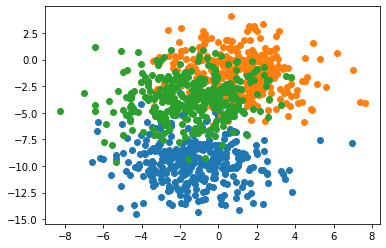

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### Multilayer Perceptron Model

Before we define a model, we need to contrive an appropriate problem for the ensemble. In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model. We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points, and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [3]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and stochastic gradient descent with a small learning rate and momentum.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

The model is fit for 500 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [5]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 98ms/step - loss: 1.0530 - accuracy: 0.4665 - val_loss: 1.0056 - val_accuracy: 0.4460
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 0.9587 - accuracy: 0.4409 - val_loss: 0.9813 - val_accuracy: 0.4190
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 0.9397 - accuracy: 0.4020 - val_loss: 0.7983 - val_accuracy: 0.5930
Epoch 4/500
4/4 [==============================] - 0s 16ms/step - loss: 0.7671 - accuracy: 0.6065 - val_loss: 0.7442 - val_accuracy: 0.6730
Epoch 5/500
4/4 [==============================] - 0s 16ms/step - loss: 0.7492 - accuracy: 0.6803 - val_loss: 0.7239 - val_accuracy: 0.6690
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 0.7397 - accuracy: 0.6602 - val_loss: 0.7000 - val_accuracy: 0.6750
Epoch 7/500
4/4 [==============================] - 0s 17ms/step - loss: 0.6472 - accuracy: 0.6795 - val_loss: 0.6752 - val_accuracy: 0.6900
Epoch 8/500
4/4 [===

4/4 [==============================] - 0s 16ms/step - loss: 0.4214 - accuracy: 0.8146 - val_loss: 0.5299 - val_accuracy: 0.7680
Epoch 60/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4254 - accuracy: 0.8085 - val_loss: 0.4957 - val_accuracy: 0.7850
Epoch 61/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3791 - accuracy: 0.8518 - val_loss: 0.4681 - val_accuracy: 0.8080
Epoch 62/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4146 - accuracy: 0.7903 - val_loss: 0.4778 - val_accuracy: 0.8040
Epoch 63/500
4/4 [==============================] - 0s 37ms/step - loss: 0.4545 - accuracy: 0.7504 - val_loss: 0.4741 - val_accuracy: 0.7990
Epoch 64/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4104 - accuracy: 0.8250 - val_loss: 0.4982 - val_accuracy: 0.7830
Epoch 65/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4118 - accuracy: 0.7907 - val_loss: 0.4775 - val_accuracy: 0.7930
Epoch 66/500
4/4 [========

4/4 [==============================] - 0s 16ms/step - loss: 0.3695 - accuracy: 0.8216 - val_loss: 0.4614 - val_accuracy: 0.7960
Epoch 118/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3155 - accuracy: 0.8634 - val_loss: 0.4525 - val_accuracy: 0.8010
Epoch 119/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3678 - accuracy: 0.7990 - val_loss: 0.4564 - val_accuracy: 0.7990
Epoch 120/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3722 - accuracy: 0.7803 - val_loss: 0.4613 - val_accuracy: 0.7980
Epoch 121/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3646 - accuracy: 0.7969 - val_loss: 0.4588 - val_accuracy: 0.7950
Epoch 122/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3372 - accuracy: 0.8087 - val_loss: 0.4767 - val_accuracy: 0.7940
Epoch 123/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3527 - accuracy: 0.8303 - val_loss: 0.5155 - val_accuracy: 0.7830
Epoch 124/500
4/4 [=

Epoch 175/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3172 - accuracy: 0.8433 - val_loss: 0.4439 - val_accuracy: 0.8130
Epoch 176/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3452 - accuracy: 0.8586 - val_loss: 0.4479 - val_accuracy: 0.8070
Epoch 177/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3083 - accuracy: 0.8436 - val_loss: 0.4605 - val_accuracy: 0.8060
Epoch 178/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3027 - accuracy: 0.8433 - val_loss: 0.4645 - val_accuracy: 0.8030
Epoch 179/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3340 - accuracy: 0.8176 - val_loss: 0.4622 - val_accuracy: 0.8130
Epoch 180/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3326 - accuracy: 0.8381 - val_loss: 0.4857 - val_accuracy: 0.8040
Epoch 181/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3268 - accuracy: 0.8455 - val_loss: 0.4735 - val_accuracy: 0.8180
Epoch 

Epoch 233/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3187 - accuracy: 0.8433 - val_loss: 0.4729 - val_accuracy: 0.8130
Epoch 234/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3101 - accuracy: 0.8402 - val_loss: 0.4798 - val_accuracy: 0.8020
Epoch 235/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3169 - accuracy: 0.8205 - val_loss: 0.4734 - val_accuracy: 0.8010
Epoch 236/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3131 - accuracy: 0.8339 - val_loss: 0.4689 - val_accuracy: 0.8160
Epoch 237/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3133 - accuracy: 0.8525 - val_loss: 0.4679 - val_accuracy: 0.8200
Epoch 238/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3016 - accuracy: 0.8495 - val_loss: 0.4749 - val_accuracy: 0.8020
Epoch 239/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3216 - accuracy: 0.8051 - val_loss: 0.4903 - val_accuracy: 0.7890
Epoch 

Epoch 291/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2934 - accuracy: 0.8672 - val_loss: 0.6484 - val_accuracy: 0.7650
Epoch 292/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4529 - accuracy: 0.8186 - val_loss: 0.6064 - val_accuracy: 0.7690
Epoch 293/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3361 - accuracy: 0.8433 - val_loss: 0.5018 - val_accuracy: 0.7900
Epoch 294/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2964 - accuracy: 0.8342 - val_loss: 0.5035 - val_accuracy: 0.7990
Epoch 295/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3581 - accuracy: 0.8061 - val_loss: 0.4794 - val_accuracy: 0.8080
Epoch 296/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3211 - accuracy: 0.8153 - val_loss: 0.5233 - val_accuracy: 0.7980
Epoch 297/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3632 - accuracy: 0.8245 - val_loss: 0.5042 - val_accuracy: 0.8080
Epoch 

Epoch 349/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3670 - accuracy: 0.7999 - val_loss: 0.4868 - val_accuracy: 0.8220
Epoch 350/500
4/4 [==============================] - 0s 36ms/step - loss: 0.2846 - accuracy: 0.8506 - val_loss: 0.5066 - val_accuracy: 0.8130
Epoch 351/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3365 - accuracy: 0.8461 - val_loss: 0.5019 - val_accuracy: 0.8060
Epoch 352/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2845 - accuracy: 0.8700 - val_loss: 0.4914 - val_accuracy: 0.8140
Epoch 353/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2977 - accuracy: 0.8216 - val_loss: 0.4867 - val_accuracy: 0.8150
Epoch 354/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2980 - accuracy: 0.8216 - val_loss: 0.4915 - val_accuracy: 0.8120
Epoch 355/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2904 - accuracy: 0.8711 - val_loss: 0.4986 - val_accuracy: 0.8120
Epoch 

Epoch 407/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2692 - accuracy: 0.8693 - val_loss: 0.5041 - val_accuracy: 0.8100
Epoch 408/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2760 - accuracy: 0.8527 - val_loss: 0.5164 - val_accuracy: 0.8130
Epoch 409/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2917 - accuracy: 0.8692 - val_loss: 0.5204 - val_accuracy: 0.8100
Epoch 410/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2895 - accuracy: 0.8452 - val_loss: 0.5264 - val_accuracy: 0.8040
Epoch 411/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3844 - accuracy: 0.8216 - val_loss: 0.5549 - val_accuracy: 0.8050
Epoch 412/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3419 - accuracy: 0.8306 - val_loss: 0.5983 - val_accuracy: 0.7890
Epoch 413/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3997 - accuracy: 0.8213 - val_loss: 0.6605 - val_accuracy: 0.7810
Epoch 

Epoch 465/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3103 - accuracy: 0.8186 - val_loss: 0.5417 - val_accuracy: 0.7820
Epoch 466/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3314 - accuracy: 0.7990 - val_loss: 0.5326 - val_accuracy: 0.7950
Epoch 467/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3084 - accuracy: 0.8165 - val_loss: 0.5398 - val_accuracy: 0.7980
Epoch 468/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2785 - accuracy: 0.8631 - val_loss: 0.5380 - val_accuracy: 0.8000
Epoch 469/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3031 - accuracy: 0.8431 - val_loss: 0.5422 - val_accuracy: 0.8210
Epoch 470/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3398 - accuracy: 0.8054 - val_loss: 0.5215 - val_accuracy: 0.8230
Epoch 471/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3475 - accuracy: 0.8205 - val_loss: 0.5539 - val_accuracy: 0.8030
Epoch 

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [6]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.850, Test: 0.808


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

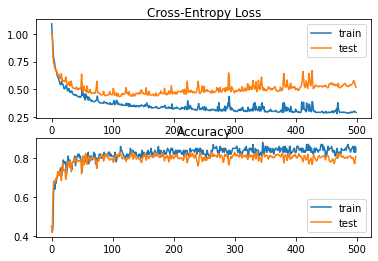

In [7]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [8]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.850, Test: 0.816


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 85% accuracy on the training dataset, which we know is optimistic, and about 81% on the test dataset, which we would expect to be more realistic.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that training accuracy is more optimistic over most of the run, as we noted with the final scores. Importantly, we do see a reasonable amount of variance in the accuracy during training on both the train and test datasets, potentially providing a good basis for using model weight averaging.

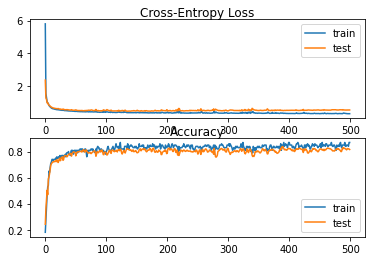

In [9]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

### Save Multiple Models to File

### New Model With Average Models Weights

### Predicting With an Average Model Weight Ensemble

### Linearly and Exponentially Decreasing Weighted Average

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Number of Models**. Evaluate the effect of many more models contributing their weights to the final model.
* **Decay Rate**. Evaluate the effect on test performance of using different decay rates for an exponentially weighted average.

## Summary

In this tutorial, you discovered how to combine the weights from multiple different models into a single model for making predictions. Specifically, you learned:

* The stochastic and challenging nature of training neural networks can mean that the optimization process does not converge.
* Creating a model with the average of the weights from models observed towards the end of a training run can result in a more stable and sometimes better-performing solution.
* How to develop final models created with the equal, linearly, and exponentially weighted average of model parameters from multiple saved models.